In [1]:
from reprophylo import *
pj = unpickle_pj('./outputs/my_project.pkpj',
                 git=False)

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened


The execution of sequence alignments and accessing them is wrapped with a rich set of functions and methods that make it very convenient to handle many of them. Therefore, it make sense to use ReproPhylo for sequence alignment, even if you do not need a tree as a final output. Although ReproPhylo rejects alignments with less than four sequences because they cannot serve for phylogenetic reconstruction.

## 3.6.1 Configuring a sequence alignment process
Sequence alignment processes are configured with the `AlnConf` class. An object of this class will generate a command-line and the required input files, but will not execute the process (this is shown below). Once the process has been successfully executed, this `AlnConf` object is stored in `pj.used_methods` and it can be invoked as a report.  
The `AlnConf` instance allows control over:

1. The program used (Mafft or Muscle)
2. Whether or not to conduct a codon alignment for CDS loci
3. The genetic code to use for codon alignment
4. The command that invokes the programme (if you want to use a programme that is not in your path)
5. The loci names of the loci to align using this specific approach
6. Custom command line arguments in order to deviate from the programme's default settings

### 3.6.1.1 Example 1: codon alignment of CDS loci with the MAFFT L-ins-i algorithm 
The next bit of code will construct an `AlnConf` instance that will align only the MT-CO1 CDS locus, by grabbing the protein sequences from `pj.records`, aligning them using the MAFFT L-ins-i algorithm, and then proceeding with a codon alignment of the CDS sequence with pal2nal, using the protein alignment as reference.

In [2]:
mafft_linsi = AlnConf(pj,                              # The Project
                      
                      method_name='mafftLinsi',        # Any unique method name,
                                                       # 'mafftDefault' by default
                      
                      CDSAlign=True,                   # Use this method to align
                                                       # protein sequences, and then
                                                       # pal2nal to align the CDSs
                                                       # This is the default setting
                                                       # and it is ignored with non-CDS
                                                       # loci.
                      
                      codontable=4,                    # The genetic code that
                                                       # applies to this data,
                                                       # codontable=1 by default
                      
                      program_name='mafft',            # mafft or muscle.
                                                       # 'mafft' by default
                      
                      cmd='mafft',                     # The command on your machine
                                                       # that invokes the program.
                                                       # 'mafft' by default
                      
                      loci=['MT-CO1'],                 # A list of loci names to align.
                                                       # loci='all' by default, which will
                                                       # align all the loci in the project.
                                                       # If loci=='all', and CDSAlign==True
                                                       # CDS loci will be aligned as proteins
                                                       # (and then at the DNA level with pal2nal)
                                                       # but other DNA loci (e.g. rRNA) will be
                                                       # alighed directly at the DNA level.
                                                        
                      cline_args={'localpair': True,   # Program specific keywords and arguments.
                                  'maxiterate': 1000}  # cine_args=={} by default, which will
                     )                                 # execute the program with default settings

mafft --localpair --maxiterate 1000 933261440758989.85_CDS_proteins_MT-CO1.fasta


### 3.6.1.2 Example 2: Alignment of rRNA loci with Muscle default algorithm
This is a simpler example where DNA loci will be directly aligned using Muscle with default settings. I am not specifying `CDSAlign=False` because this is not a CDS locus so there will be no attempt to do a codon alignment. the `codontable` argument is also ignored. I am also not specifying `cmd='muscle'`, because when we set `program='muscle'`, then the default value of `cmd` becomes `'muscle'`.  
  
(hint: by the way, if you have a reference alignment which accounts for the secondary structure on your RNA locus, it can be utilized with the `seed` argument in Mafft). 

In [3]:
muscle_defaults = AlnConf(pj,
                          method_name="muscleDefault",
                          program_name="muscle",
                          loci=['18s','28s'])

muscle -in 375991440758992.65_18s.fasta
muscle -in 375991440758992.65_28s.fasta


## 3.6.2 Executing sequence alignment processes
Once we have one or more `AlnConf` objects, we can execute them in one go using the `Project` method `align`. This method accepts a list of `AlnConf` objects and does whatever it is each of them tells it:

In [4]:
pj.align([mafft_linsi, muscle_defaults])

When the process is done, the `AlnConf` objects will be stored in `pj.used_methods`, which is a dictionary using the method names as keys:

In [5]:
pj.used_methods

{'mafftLinsi': <reprophylo.AlnConf instance at 0x7f103c1f7128>,
 'muscleDefault': <reprophylo.AlnConf instance at 0x7f103ba20050>}

if we print one of these `AlnConf` objects as a string, we will get complete details about the process, including programme versions and references:

In [6]:
print pj.used_methods['mafftLinsi']

AlnConf named mafftLinsi with ID 933261440758989.85
Loci: MT-CO1 
Created on: Fri Aug 28 11:49:49 2015
Commands:
MT-CO1: mafft --localpair --maxiterate 1000 933261440758989.85_CDS_proteins_MT-CO1.fasta

Environment:
Platform: Linux-3.13.0-40-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultJun 22 2015 17:58:13
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2rev1056
 biopython version: 1.64
 dendropy version: 3.12.0
 cloud version: 2.8.5
 reprophylo version 1.0
 User: amir-TECRA-W50-A
 Program and version: MAFFT v7.123b\nPal2Nal v14
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.\nMikita Suyama
 David Torrents
 and Peer Bork (2006) PAL2NAL: robust conversion of protein sequence alignments into the corresponding codon alignments.Nucleic Acids Res. 34
 W609-W612.
execution 

## 3.6.3 Accessing sequence alignments
### 3.6.3.1 The `pj.alignments` dictionary
The alignments themselves are stored in the `pj.alignments` dictionary, using keys that follow this pattern: `locus_name@method_name` where `method_name` is the name you have provided to your `AlnConf` object.

In [9]:
pj.alignments

{'18s@muscleDefault': <<class 'Bio.Align.MultipleSeqAlignment'> instance (52 records of length 1824, IUPACProtein()) at 7f103bba6790>,
 '28s@muscleDefault': <<class 'Bio.Align.MultipleSeqAlignment'> instance (48 records of length 909, IUPACProtein()) at 7f103be32310>,
 'MT-CO1@mafftLinsi': <<class 'Bio.Align.MultipleSeqAlignment'> instance (73 records of length 1227, IUPACAmbiguousDNA()) at 7f103bbc1350>}

### 3.6.3.2 Accessing a `MultipleSeqAlignment` object
An alignment can be easily accessed and manipulated with any of [Biopython's `AlignIO` tricks](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc67) using the `fa` `Project` method:

In [10]:
print pj.fa('18s@muscleDefault')[:4,410:420].format('phylip-relaxed')

returning alignment object 18s@muscleDefault
 4 10
KC762720.1_f0  GAGAAACGGC 
KC774024.1_f0  GAGAAACGGC 
KC762713.1_f0  GAGAAACGGC 
KC762708.1_f0  GAGAAACGGC 



### 3.6.3.3 Writing sequence alignment files
Alignment text files can be dumped in any [`AlignIO` format](http://biopython.org/wiki/AlignIO#File_Formats) for usage in an external command line or GUI program. When writing to files, you can control the header of the sequence by, for example, adding the organism name of the gene name, or by replacing the feature ID with the record ID:

In [11]:
# record_id and source_organism are feature qualifiers in the SeqRecord object
# See section 3.4
files = pj.write_alns(id=['record_id','source_organism'],
                      format='fasta')
files

['28s@muscleDefault_aln.fasta',
 '18s@muscleDefault_aln.fasta',
 'MT-CO1@mafftLinsi_aln.fasta']

The files will always be written to the current working directory (where this notebook file is), and can immediately be moved programmatically to avoid clutter: 

In [12]:
# make a new directory for your alignment files:
if not os.path.exists('alignment_files'):
    os.mkdir('alignment_files')
    
# move the files there
for f in files:
    os.rename(f, "./alignment_files/%s"%f)

### 3.6.3.4 Viewing alignments
ReproPhylo has a `Project` method to view the alignments in the browser. This one also allows you to control the content of sequence headers.

In [13]:
pj.show_aln('MT-CO1@mafftLinsi',id=['source_organism'])
# source_organism is a feature qualifier in the SeqRecord object
# See section 3.4

As a result of this command, a new browser tab will open, showing the alignment.  
**Note1:** In some cases, the tab will not open automatically, you will need to look for the html file in your working directory and open it manually.  
**Note2:** This is slow with large alignment. A better approach with large files would be to write a text file, as above, and look at the alignment in [AliView](http://www.ormbunkar.se/aliview/) or any of your preferred alignment viewers.

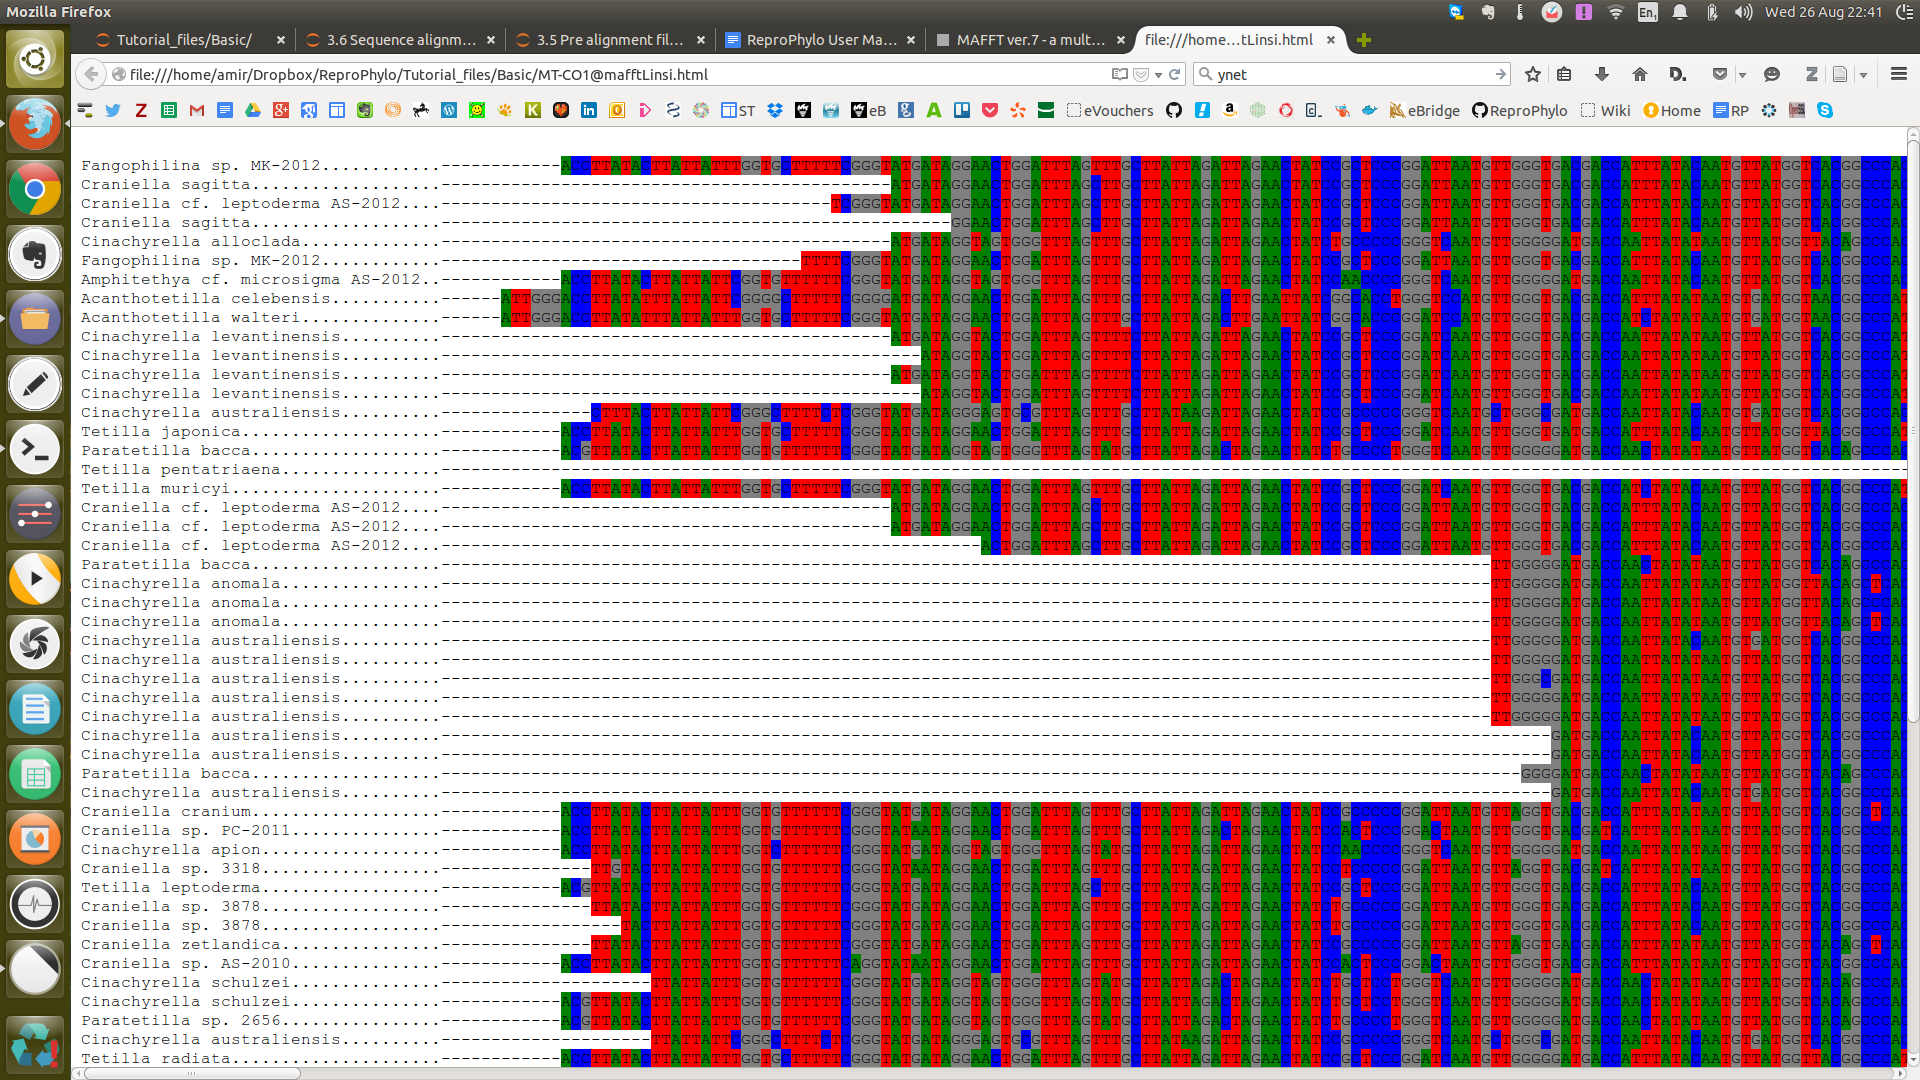

In [14]:
from IPython.display import Image
Image('./images/show_aln_example.png', width=700)

In [16]:
pickle_pj(pj, 'outputs/my_project.pkpj')

'outputs/my_project.pkpj'

## 3.6.4  Quick reference

In [ ]:
# Make a AlnConf object
alnconf = AlnConf(pj, **kwargs)

# Execute alignment process
pj.align([alnconf])

# Show AlnConf description
print pj.used_methods['method_name']

# Fetch a MultipleSeqAlignment object
aln_obj = pj.fa('locus_name@method_name')

# Write alignment text files
pj.write_alns(id=['some_feature_qualifier'], format='fasta')
# the default feature qualifier is 'feature_id'
# 'fasta' is the default format

# View alignment in browser
pj.show_aln('locus_name@method_name',id=['some_feature_qualifier'])